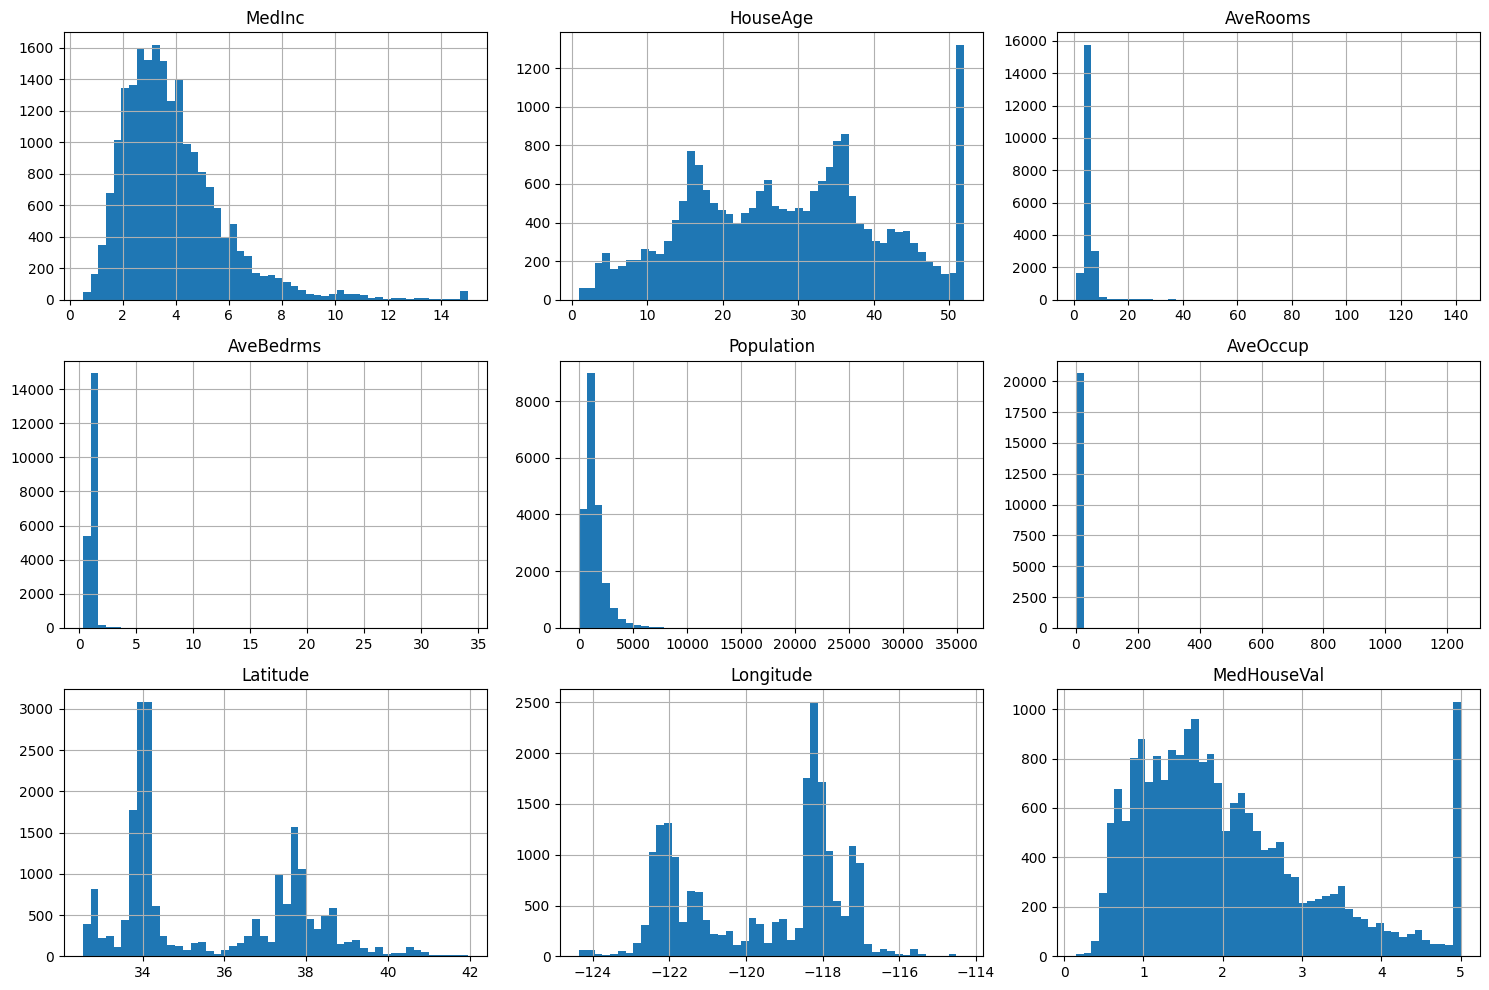

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing

# Load dataset
housing = fetch_california_housing(as_frame=True)
df = housing.frame

# Plot histograms
df.hist(bins=50, figsize=(15,10))
plt.tight_layout()
plt.show()

In [3]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
import numpy as np

df["income_cat"] = pd.cut(df["MedInc"],
                          bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                          labels=[1,2,3,4,5])

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]



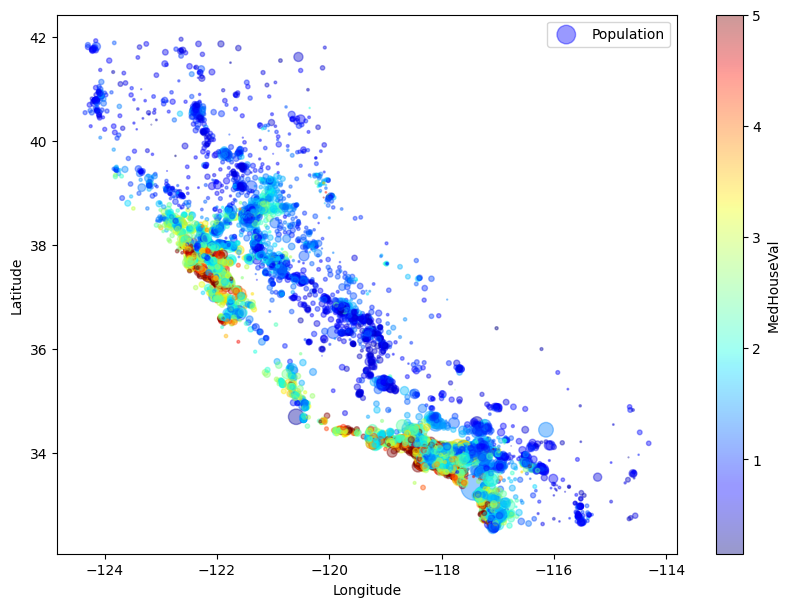

In [4]:
housing = strat_train_set.copy()

housing.plot(kind="scatter",
             x="Longitude",
             y="Latitude",
             alpha=0.4,
             s=housing["Population"]/100,
             label="Population",
             figsize=(10,7),
             c="MedHouseVal",
             cmap="jet",
             colorbar=True)

plt.legend()
plt.show()


In [5]:
corr_matrix = housing.corr()
corr_matrix["MedHouseVal"].sort_values(ascending=False)


,MedHouseVal
MedHouseVal,1.000000
MedInc,0.687151
income_cat,0.642256
AveRooms,0.146255
HouseAge,0.114146
AveOccup,-0.021991
Population,-0.026882
AveBedrms,-0.043294
Longitude,-0.047466
Latitude,-0.142673


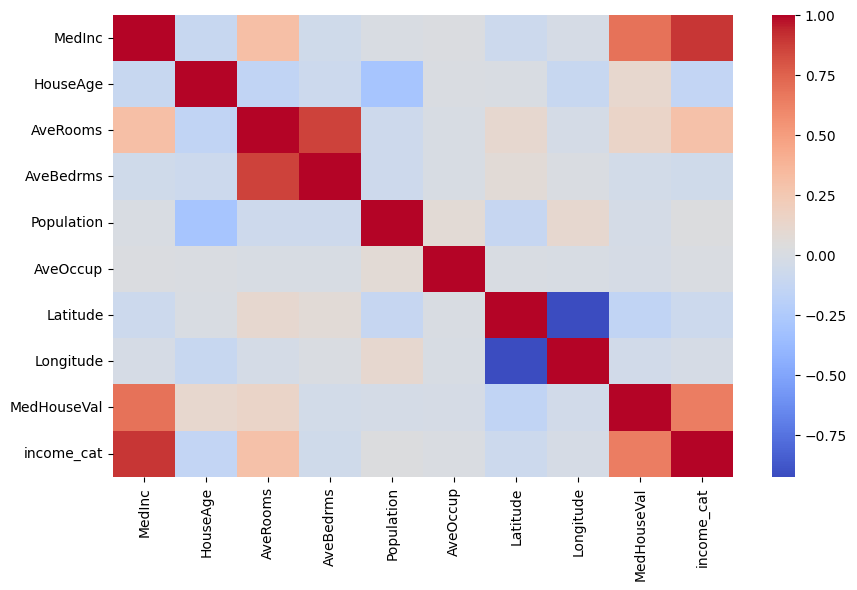

In [6]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, cmap="coolwarm")
plt.show()


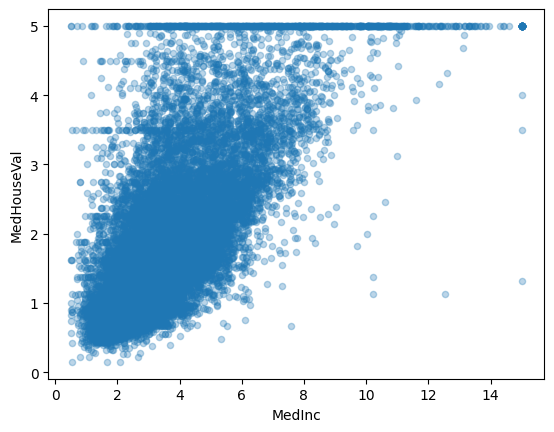

In [7]:
housing.plot(kind="scatter", x="MedInc", y="MedHouseVal", alpha=0.3)
plt.show()


In [8]:
housing["rooms_per_household"] = housing["AveRooms"] / housing["HouseAge"]
housing["bedrooms_per_room"] = housing["AveBedrms"] / housing["AveRooms"]
housing["population_per_household"] = housing["Population"] / housing["AveOccup"]

corr_matrix = housing.corr()
corr_matrix["MedHouseVal"].sort_values(ascending=False)


,MedHouseVal
MedHouseVal,1.000000
MedInc,0.687151
income_cat,0.642256
AveRooms,0.146255
HouseAge,0.114146
population_per_household,0.064590
rooms_per_household,0.026171
AveOccup,-0.021991
Population,-0.026882
AveBedrms,-0.043294


In [10]:
from sklearn.impute import SimpleImputer

housing_num = housing.drop("income_cat", axis=1)

imputer = SimpleImputer(strategy="median")
housing_num_imputed = imputer.fit_transform(housing_num)


In [11]:
from sklearn.preprocessing import OneHotEncoder

# Example:
# housing_cat = housing[["ocean_proximity"]]
# encoder = OneHotEncoder()
# housing_cat_1hot = encoder.fit_transform(housing_cat)

# To view categories:
# encoder.categories_


In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        rooms_per_household = X[:, 3] / X[:, 1]
        bedrooms_per_room = X[:, 4] / X[:, 3]
        population_per_household = X[:, 5] / X[:, 6]

        return np.c_[X,
                     rooms_per_household,
                     bedrooms_per_room,
                     population_per_household]


In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('scaler', StandardScaler())
])

In [15]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num.columns)

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)
